In [1]:
import numpy as np
import matplotlib.pylab as plt
from astropy.table import Table
import pandas as pd

In [2]:
# Open the templates
templates = Table.read('files/template_colors_izYJHKsW1W2_z.fits')
templates = templates.to_pandas()

# If the objects already have an spectral type and you want to check the classification from this code
literature = True

if literature == True:
    # Open calibration file -- literature
    objects_file = Table.read('files/Best+2020_DES_VHS_AllWISE_bands.fits')
    objects_file = objects_file.to_pandas()
    sptnum = objects_file['sptnumabs_formula']
else:
    # Open a file without any information about the spectral type
    objects_file = Table.read('OBJECTS TO CLASSIFY -- CHANGE HERE')
    objects_file = objects_file.to_pandas()

# Magnitude and errors cols names
mag_cols = ['PSF_MAG_I', 'PSF_MAG_Z', 'PSF_MAG_Y', 'JAPERMAG3', 'HAPERMAG3', 'KSAPERMAG3', 'W1mag', 'W2mag']
err_cols = ['PSF_MAG_ERR_I', 'PSF_MAG_ERR_Z', 'PSF_MAG_ERR_Y', 'JAPERMAG3ERR', 'HAPERMAG3ERR', 'KSAPERMAG3ERR', 'e_W1mag', 'e_W2mag']

magnitudes = {band: objects_file[col].values for band, col in zip(['i', 'z', 'Y', 'J', 'H', 'Ks', 'W1', 'W2'], mag_cols)}
errors = {band: objects_file[col].values for band, col in zip(['i', 'z', 'Y', 'J', 'H', 'Ks', 'W1', 'W2'], err_cols)}

# Template spectral type and photometry
SPT = templates['SpT'].values
cbts = {band: templates[f'{band}_z'].values for band in ['i', 'z', 'Y', 'J', 'H', 'Ks', 'W1', 'W2']}

In [3]:
rms = True
# Set the intrinsic errors
mags_rms = {band: [0.2]*len(SPT) for band in ['i', 'z', 'Y', 'J', 'H', 'Ks', 'W1', 'W2']}

# For each object, calculate the best fitting spectral type
allxi2, diff, bestfit, nbands = [], [], [], []

for i, zz in enumerate(magnitudes['z']):
    bands = {band: magnitudes[band][i] not in [37.5, -99.] and errors[band][i] < 0.4 for band in magnitudes}
    
    # For each template, this is the inverse variance weighted estimate of the reference magnitude, in our case, z:
    mreft = []
    for ii, sspt in enumerate(SPT):
        mup, mdown = 0., 0.
        for band in bands:
            if bands[band]:
                temp_err = np.sqrt(errors[band][i]**2 + mags_rms[band][ii]**2)
                mup += (magnitudes[band][i] - cbts[band][ii]) / temp_err**2
                mdown += 1 / temp_err**2
        mreft.append(mup / mdown)
    
    # Calculate chi-squared for each spectral type
    xi2 = []
    for ii, sspt in enumerate(SPT):
        xitemp = sum(((magnitudes[band][i] - mreft[ii] - cbts[band][ii]) / np.sqrt(errors[band][i]**2 + mags_rms[band][ii]**2))**2
                     for band in bands if bands[band])
        xi2.append(xitemp)
    
    # Number of valid bands
    numberofbands = sum(bands.values())
    
    # Save results
    allxi2.append(np.min(xi2))
    bestfit.append(SPT[np.argmin(xi2)])
    nbands.append(numberofbands)
    
    if literature == True:
        diff.append(sptnum[i] - SPT[np.argmin(xi2)])

objects_file['chi2'] = allxi2
objects_file['best_fit'] = bestfit
objects_file['n_bands'] = nbands

# If you want to save the results
#objects_file_table = Table.from_pandas(objects_file)
#objects_file_table.write('SOME NAME HERE .csv',overwrite=True)

In [4]:
# This function calculates the accuracy for L and T dwarfs -- it refers to a comparison with literarute
def spectral_data(sptnum, nbands, bestfit, diff):
    spt_L = (sptnum <=19) & (np.array(nbands) >= 6)
    spt_T = (sptnum >=20) & (np.array(nbands) >= 6)

    diffL = np.array(sptnum)[spt_L] - np.array(bestfit)[spt_L] 
    diffT = np.array(sptnum)[spt_T] - np.array(bestfit)[spt_T]

    sigmaL = ((np.sum(np.abs(diffL)))/len(diffL))*((np.sqrt(2*np.pi))/2)
    sigmaT = ((np.sum(np.abs(diffT)))/len(diffT))*((np.sqrt(2*np.pi))/2)

    return(sigmaL, sigmaT)

sigma L-Type: 1.738498628943708 sigma T-Type: 1.0930065151007269


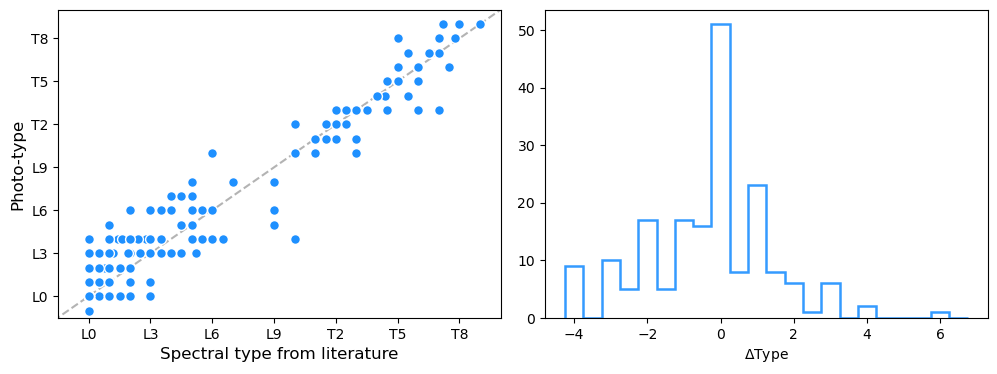

In [5]:
# Some basic comparison plot
if literature == True:
    sigmaL, sigmaT, = spectral_data(sptnum, nbands, bestfit, diff)
    print('sigma L-Type:',sigmaL,'sigma T-Type:',sigmaT)

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    fig.subplots_adjust(wspace=0.1)
    
    ax0.scatter(sptnum, bestfit, s=50, color='dodgerblue',zorder=1, edgecolors='white')
    ax0.plot([1.,30.],[1.,30.], color='dimgray',zorder=0, alpha= 0.5, linestyle='--')
    
    ticks=[10, 13, 16, 19, 22, 25, 28]
    ax0.set_xticks(ticks)
    ax0.set_xticklabels(('L0','L3','L6','L9','T2','T5','T8'))
    ax0.set_yticks(ticks)
    ax0.set_yticklabels(('L0','L3','L6','L9','T2','T5','T8'))
    ax0.set_xlim([8.5,30.])
    ax0.set_ylim([8.5,30.])
    ax0.set_xlabel('Spectral type from literature', size=12)
    ax0.set_ylabel('Photo-type', size=12)

    ax1.hist(diff, bins=22, range=[-4,7], histtype='step', align='left', lw=1.8, alpha=0.9, 
             color='dodgerblue',log=False)
    ax1.set_xlabel('$\Delta$Type')

else:
    LT_only = (np.array(bestfit) >= 10) & (np.array(nbands) >= 6)

    plt.hist(bestfit[LT_only], range=(10,30), bins=20, histtype='bar', rwidth=0.88, 
             log=True, color='darkorange', alpha=0.8, align='left')
    ticks=[10,13,16,19,22,25,28]
    plt.xticks(ticks,['L0','L3','L6','L9','T2','T5','T8'])
    plt.xlabel('Photo-type')
    plt.ylabel('Counts')
    plt.show()  